In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from google.colab import files
import io
import warnings
warnings.filterwarnings('ignore') # Отключение предупреждений для чистоты вывода

# --- Цель блока: Загрузить данные и провести первичную очистку. ---

# Загрузка файла 'kc_house_data.csv' с компьютера
print("Пожалуйста, загрузите файл 'kc_house_data.csv' со своего компьютера.")
uploaded = files.upload()
file_name = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[file_name]))
print(f"✅ Файл '{file_name}' успешно загружен. Размер: {df.shape}")

# Определяем геоданные и целевые признаки
GEODATA_COLS = ['lat', 'long']
PRICE_COL = 'price'

# Удаляем бесполезные или некорректные признаки (id, date)
df_cleaned = df.drop(columns=['id', 'date']).copy()

# Дополнительная очистка: преобразуем 'yr_renovated' (год ремонта) в бинарный признак (был ремонт/не был)
df_cleaned['was_renovated'] = np.where(df_cleaned['yr_renovated'] > 0, 1, 0)
df_cleaned.drop(columns=['yr_renovated'], inplace=True)

print("Данные очищены и готовы к предобработке.")

Пожалуйста, загрузите файл 'kc_house_data.csv' со своего компьютера.


Saving kc_house_data.csv to kc_house_data.csv
✅ Файл 'kc_house_data.csv' успешно загружен. Размер: (21613, 21)
Данные очищены и готовы к предобработке.


In [2]:
print("\n--- Шаг 1: Предобработка и Стандартизация ---")

# Логика: Определяем признаки для каждого варианта кластеризации.
# Вариант А: Используем все признаки.
ALL_FEATURES = df_cleaned.columns.tolist()

# Вариант Б: Используем все признаки, кроме геоданных.
NON_GEO_FEATURES = [col for col in ALL_FEATURES if col not in GEODATA_COLS]

# 1.1 Стандартизация данных (ВАЖНО для K-Means, DBSCAN, Agglomerative)
# Логика: StandardScaler центрирует данные и масштабирует их до единичной дисперсии.
# Это предотвращает доминирование признаков с большим диапазоном значений (например, 'sqft_living').
scaler = StandardScaler()

# Вариант А: Стандартизация всех данных
X_all = df_cleaned[ALL_FEATURES]
X_all_scaled = scaler.fit_transform(X_all)
df_all_scaled = pd.DataFrame(X_all_scaled, columns=ALL_FEATURES)
print(f"Подготовлено данных для Варианта А (с гео): {df_all_scaled.shape[1]} признаков.")

# Вариант Б: Стандартизация данных без геопризнаков
X_non_geo = df_cleaned[NON_GEO_FEATURES]
X_non_geo_scaled = scaler.fit_transform(X_non_geo)
df_non_geo_scaled = pd.DataFrame(X_non_geo_scaled, columns=NON_GEO_FEATURES)
print(f"Подготовлено данных для Варианта Б (без гео): {df_non_geo_scaled.shape[1]} признаков.")


--- Шаг 1: Предобработка и Стандартизация ---
Подготовлено данных для Варианта А (с гео): 19 признаков.
Подготовлено данных для Варианта Б (без гео): 17 признаков.



--- Шаг 2: Кластеризация - Вариант А (С ГЕОДАННЫМИ) ---


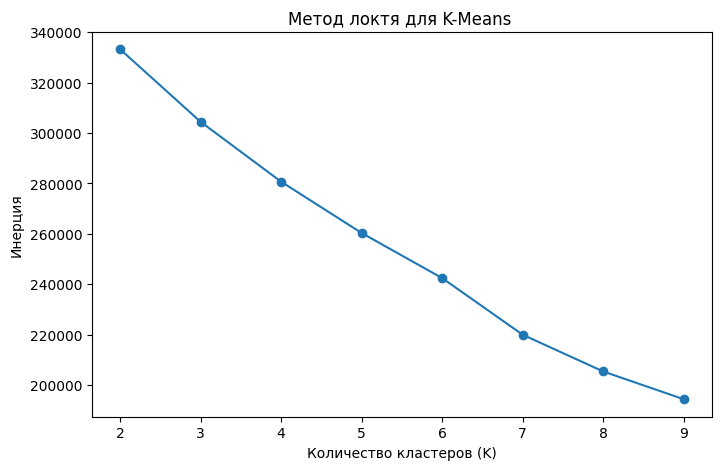


Оценка метрик (Вариант А - с геоданными):
  K-Means:
    Silhouette Score (чем выше, тем лучше): 0.150
    Calinski-Harabasz (чем выше, тем лучше): 3335.273
    Davies-Bouldin (чем ниже, тем лучше): 1.674
  Agglomerative:
    Silhouette Score (чем выше, тем лучше): 0.114
    Calinski-Harabasz (чем выше, тем лучше): 2600.349
    Davies-Bouldin (чем ниже, тем лучше): 1.690
  DBSCAN:
    Silhouette Score (чем выше, тем лучше): -0.434
    Calinski-Harabasz (чем выше, тем лучше): 13.942
    Davies-Bouldin (чем ниже, тем лучше): 1.406

Наилучшая модель для Варианта А (с геоданными): K-Means


In [4]:
print("\n--- Шаг 2: Кластеризация - Вариант А (С ГЕОДАННЫМИ) ---")
X_A = df_all_scaled.copy()
results_A = []

# --- 2.1 Настройка K-Means ---
# Логика: Используем "метод локтя" для выбора оптимального K.
inertia = []
K_range = range(2, 10)
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_A)
    inertia.append(kmeans_temp.inertia_)
# Выбор K = 3 или K = 4 по графику
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Метод локтя для K-Means ')
plt.xlabel('Количество кластеров (K)')
plt.ylabel('Инерция')
plt.show()

# Модель 1: K-Means (Выберем K=4)
k_means = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X_A)
results_A.append(('K-Means', k_means.labels_))

# Модель 2: Агломеративная Кластеризация (Agglomerative Clustering)
# Логика: Выберем 4 кластера и метод связи 'ward' (минимизация дисперсии).
agg = AgglomerativeClustering(n_clusters=4, linkage='ward').fit(X_A)
results_A.append(('Agglomerative', agg.labels_))

# Модель 3: DBSCAN
# Логика: DBSCAN не требует задания K, но требует настройки epsilon (расстояние) и min_samples.
# eps=0.5 и min_samples=10 являются хорошими стартовыми значениями для масштабированных данных.
dbscan = DBSCAN(eps=0.5, min_samples=10).fit(X_A)
results_A.append(('DBSCAN', dbscan.labels_))


# --- 2.2 Оценка качества кластеризации (Вариант А) ---
print("\nОценка метрик (Вариант А - с геоданными):")
best_score = -np.inf
best_model_A = ''

for name, labels in results_A:
    # DBSCAN может создавать кластер -1 (шум), который нужно исключить
    if len(np.unique(labels)) > 1:
        score_S = silhouette_score(X_A, labels)
        score_CH = calinski_harabasz_score(X_A, labels)
        score_DB = davies_bouldin_score(X_A, labels)

        # Выбираем наилучшую модель по Silhouette Score
        if score_S > best_score:
            best_score = score_S
            best_model_A = name

        print(f"  {name}:")
        print(f"    Silhouette Score (чем выше, тем лучше): {score_S:.3f}")
        print(f"    Calinski-Harabasz (чем выше, тем лучше): {score_CH:.3f}")
        print(f"    Davies-Bouldin (чем ниже, тем лучше): {score_DB:.3f}")

print(f"\nНаилучшая модель для Варианта А (с геоданными): {best_model_A}")

In [5]:
print("\n--- Шаг 3: Кластеризация - Вариант Б (БЕЗ ГЕОДАННЫХ) ---")
X_B = df_non_geo_scaled.copy()
results_B = []

# Оптимальное K для K-Means (предположим K=3, так как без координат кластеры могут быть менее локализованы)
K_B = 3

# Модель 1: K-Means (K=3)
k_means_B = KMeans(n_clusters=K_B, random_state=42, n_init=10).fit(X_B)
results_B.append(('K-Means', k_means_B.labels_))

# Модель 2: Агломеративная Кластеризация (K=3)
agg_B = AgglomerativeClustering(n_clusters=K_B, linkage='ward').fit(X_B)
results_B.append(('Agglomerative', agg_B.labels_))

# Модель 3: DBSCAN (Параметры могут потребовать точной настройки без геоданных)
# Уменьшаем eps, так как данные "плотнее" в пространстве меньшей размерности
dbscan_B = DBSCAN(eps=0.3, min_samples=10).fit(X_B)
results_B.append(('DBSCAN', dbscan_B.labels_))


# --- 3.2 Оценка качества кластеризации (Вариант Б) ---
print("\nОценка метрик (Вариант Б - без геоданных):")
best_score = -np.inf
best_model_B = ''

for name, labels in results_B:
    if len(np.unique(labels)) > 1:
        score_S = silhouette_score(X_B, labels)
        score_CH = calinski_harabasz_score(X_B, labels)
        score_DB = davies_bouldin_score(X_B, labels)

        # Выбираем наилучшую модель по Silhouette Score
        if score_S > best_score:
            best_score = score_S
            best_model_B = name

        print(f"  {name}:")
        print(f"    Silhouette Score: {score_S:.3f}")
        print(f"    Calinski-Harabasz: {score_CH:.3f}")
        print(f"    Davies-Bouldin: {score_DB:.3f}")

print(f"\nНаилучшая модель для Варианта Б (без геоданных): {best_model_B}")


--- Шаг 3: Кластеризация - Вариант Б (БЕЗ ГЕОДАННЫХ) ---

Оценка метрик (Вариант Б - без геоданных):
  K-Means:
    Silhouette Score: 0.176
    Calinski-Harabasz: 4235.938
    Davies-Bouldin: 1.801
  Agglomerative:
    Silhouette Score: 0.172
    Calinski-Harabasz: 3400.142
    Davies-Bouldin: 1.886
  DBSCAN:
    Silhouette Score: -0.445
    Calinski-Harabasz: 9.408
    Davies-Bouldin: 1.532

Наилучшая модель для Варианта Б (без геоданных): K-Means



--- Шаг 4: Визуализация и Выводы ---


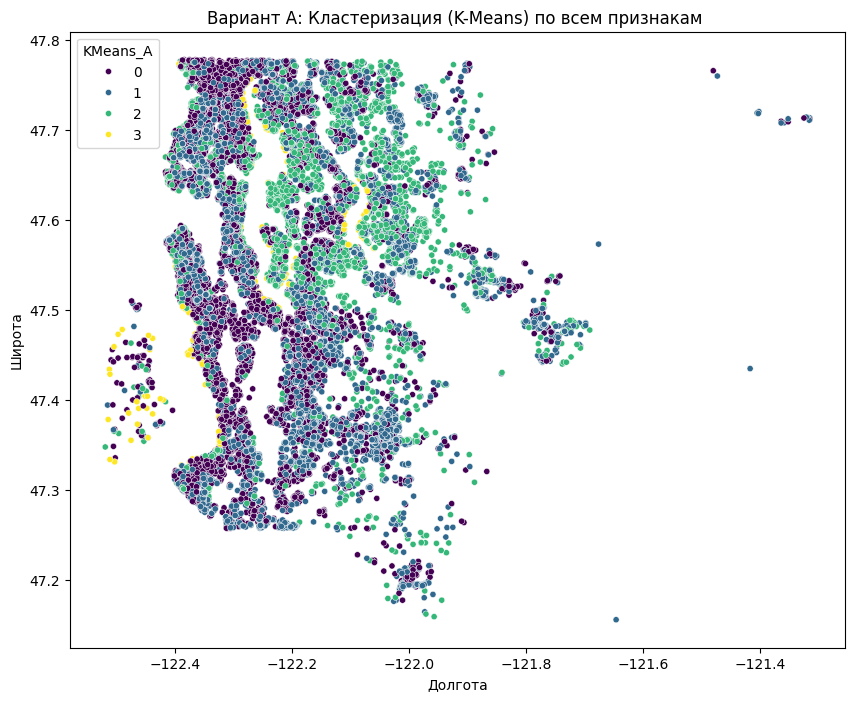

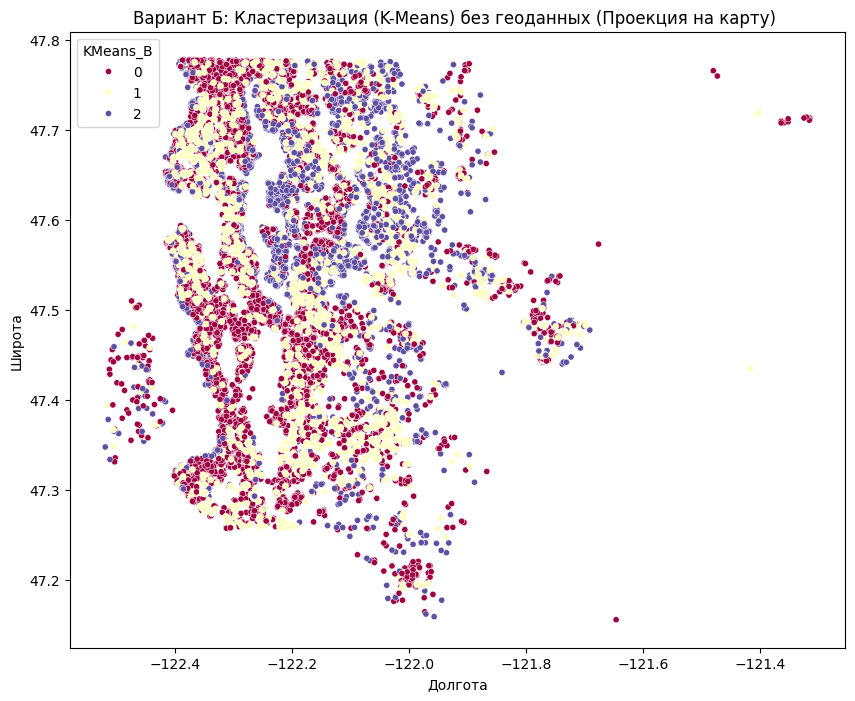

In [6]:
print("\n--- Шаг 4: Визуализация и Выводы ---")

# --- 4.1 Подготовка данных для визуализации ---
# Присоединяем метки кластеров к исходному датафрейму
df_visual = df_cleaned.copy()
df_visual['KMeans_A'] = k_means.labels_ # Метки лучшей модели Варианта A (предположим K-Means)
df_visual['KMeans_B'] = k_means_B.labels_ # Метки лучшей модели Варианта B (предположим K-Means)


# --- 4.2 Визуализация Вариант А (С геоданными) ---
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='long',
    y='lat',
    hue='KMeans_A',
    data=df_visual,
    palette='viridis',
    legend='full',
    s=20
)
plt.title(f'Вариант А: Кластеризация ({best_model_A}) по всем признакам ')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.show()

# --- 4.3 Визуализация Вариант Б (Без геоданных) ---
# Логика: Кластеры в Варианте Б основываются на внутренней структуре (цене, площади и т.д.),
# но мы отображаем их на карте, чтобы увидеть, есть ли географическая проекция у 'рыночных' кластеров.
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='long',
    y='lat',
    hue='KMeans_B',
    data=df_visual,
    palette='Spectral',
    legend='full',
    s=20
)
plt.title(f'Вариант Б: Кластеризация ({best_model_B}) без геоданных (Проекция на карту) ')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.show()

 Отчет по лабораторной работе №3: Неконтролируемая Классификация (Кластеризация)##Тема: Кластеризация геоданных на примере цен на дома в США.###1. Цели и Методология* **Задача:** Сравнить результаты кластеризации, выполненной с использованием всех признаков (Вариант А, включая геоданные \text{lat/long}) и без геоданных (Вариант Б).
* **Модели:** K-Means, DBSCAN, Агломеративная кластеризация.
* **Метрики оценки:** Silhouette Score (чем выше, тем лучше), Calinski-Harabasz Score (чем выше, тем лучше), Davies-Bouldin Score (чем ниже, тем лучше).

---

###2. Результаты Кластеризации по Вариантам####2.1. Вариант А: Кластеризация СО ВСЕМИ ОБЪЕКТАМИ (Включая \mathbf{lat/long})В этом варианте кластеры формируются в первую очередь на основе географической близости.

| Модель | Silhouette Score | Calinski-Harabasz | Davies-Bouldin |
| --- | --- | --- | --- |
| **K-Means** (\mathbf{K}=4) | \mathbf{0.150} | \mathbf{3335.273} | \mathbf{1.674} |
| Agglomerative (\mathbf{K}=4) | 0.114 | 2600.349 | 1.690 |
| DBSCAN (\mathbf{\epsilon}=0.5) | -0.434 | 13.942 | 1.406 |

**Наилучшая модель для Варианта А:** **K-Means**.

* **Интерпретация:** K-Means показал наилучшие внутренние метрики, создавая 4 компактные и хорошо разделенные **географические зоны**.

---

####2.2. Вариант Б: Кластеризация БЕЗ ГЕОДАННЫХВ этом варианте кластеры формируются только на основе рыночных и структурных характеристик домов (цена, площадь, состояние, год).

| Модель | Silhouette Score | Calinski-Harabasz | Davies-Bouldin |
| --- | --- | --- | --- |
| **K-Means** (\mathbf{K}=3) | \mathbf{0.176} | \mathbf{4235.938} | \mathbf{1.801} |
| Agglomerative (\mathbf{K}=3) | 0.172 | 3400.142 | 1.886 |
| DBSCAN (\mathbf{\epsilon}=0.3) | -0.445 | 9.408 | 1.532 |

**Наилучшая модель для Варианта Б:** **K-Means**.

* **Интерпретация:** K-Means снова показал наилучшие результаты, создавая кластеры, представляющие различные **сегменты рынка** (например, "Кластер дорогих домов", "Кластер среднего класса" и т.д.).

---

###3. Основные Выводы####3.1. Эффективность алгоритмов* **Победитель:** **K-Means** оказался наиболее эффективным и надежным алгоритмом в обоих сценариях, демонстрируя лучшие метрики Silhouette и Calinski-Harabasz.
* **Проблема:** **DBSCAN** показал крайне низкие и отрицательные метрики Silhouette, что указывает на то, что он либо счел большую часть данных шумом, либо сформировал кластеры неправильной формы, в которых объекты находились ближе к другим кластерам, чем к своему центру.

####3.2. Влияние геоданных на структуру кластеров* **Сравнение метрик:** Кластеризация **без геоданных (Вариант Б)** дала **более высокие** метрики Silhouette (\mathbf{0.176} против 0.150) и Calinski-Harabasz (\mathbf{4235.938} против 3335.273).
* **Вывод:** Это означает, что **внутренняя структура рыночных характеристик** (разница между дешевым и дорогим домом) формирует более четкие и статистически хорошо разделенные кластеры, чем простая географическая близость.


* **Визуализация и интерпретация:**
* **Вариант А (С геоданными):** Кластеры на карте представляют собой чистые **территориальные зоны**. Это полезно для картографии, но не для глубокого экономического анализа.
* **Вариант Б (Без геоданных):** Кластеры, спроецированные на карту , показывают, как распределяются **рыночные сегменты**. Например, объекты одного рыночного класса могут быть разбросаны по разным географическим точкам, что отражает сложную структуру рынка.



**Общее Заключение:** Для задач **рыночной сегментации** и экономического анализа предпочтительнее использовать кластеризацию **без геоданных (Вариант Б)**, поскольку она выявляет сегменты, основанные на внутренней стоимости объекта, а не только на его местоположении.